In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load Data and define utility functions

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [7]:
x_train_close = x_train[:,:,4] 
y_train_close = y_train[:,:,4] 
x_test_close = x_test[:,:,4] 

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1) 
close_prices.shape

(7661, 1500)

In [8]:
x_train_close.shape, y_train_close.shape, x_test_close.shape, close_prices.shape

((7661, 1380), (7661, 120), (535, 1380), (7661, 1500))

# Preprocess Data
Given time series data (t_1, t_2, ..., tN) predict t{N+K} Here, we let K = 120 and N is a hyperparameter, but we can let it be 60 minutes.

In [10]:
K = 120 
N = 60 
seq_len = 1500 
features = 1
X = [] 
Y = [] 

for j in tqdm(range(close_prices.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X.append(close_prices[j, i:i+N]) 
        Y.append(close_prices[j, i+N+K]) 
        i += 1   
        
        
X = np.asarray(X) 
Y = np.asarray(Y)

X.shape, Y.shape

100%|██████████| 7661/7661 [00:10<00:00, 742.85it/s]


((10112520, 60), (10112520,))

# Define Model

In [12]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 2, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    
def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    inputs = Input((N, features))
    bn = BatchNormalization()(inputs)
    x = Conv1D(node*2, 5, activation = activation)(bn) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    x = transformer_block(x, node, drop_rate, activation) 
        
    x = GlobalMaxPooling1D()(x)
    x = Dropout(drop_rate)(x) 
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs,outputs=x) 
    model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [13]:
model = build_transformer() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 56, 128)      768         batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 18, 128)      0           conv1d[0][0]                     
______________________________________________________________________________________________

In [14]:
model_path = 'Transformer_N+K_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 32, 
                    epochs = 20, 
                    callbacks = [learning_rate_reduction, checkpoint], 
                    validation_split = 0.1)


Epoch 1/20
284415/284415 [==============================] - 1769s 6ms/step - loss: 0.0020 - mae: 0.0184 - mse: 0.0020 - mape: 1.8411 - val_loss: 5.3970e-04 - val_mae: 0.0133 - val_mse: 5.3970e-04 - val_mape: 1.3272

Epoch 00001: val_loss improved from inf to 0.00054, saving model to Transformer_N+K_epoch_001_val_0.001.h5
Epoch 2/20
284415/284415 [==============================] - 1761s 6ms/step - loss: 3.4119e-04 - mae: 0.0119 - mse: 3.4119e-04 - mape: 1.1949 - val_loss: 4.8873e-04 - val_mae: 0.0122 - val_mse: 4.8873e-04 - val_mape: 1.2126

Epoch 00002: val_loss improved from 0.00054 to 0.00049, saving model to Transformer_N+K_epoch_002_val_0.000.h5
Epoch 3/20
277560/284415 [============================>.] - ETA: 40s - loss: 3.3891e-04 - mae: 0.0119 - mse: 3.3891e-04 - mape: 1.1905

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 50733/284415 [====>.........................] - ETA: 22:46 - loss: 3.3722e-04 - mae: 0.0119 - mse: 3.3722e-04 - mape: 1.1884

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



110492/284415 [==========>...................] - ETA: 16:58 - loss: 3.3809e-04 - mae: 0.0119 - mse: 3.3809e-04 - mape: 1.1887

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



169421/284415 [================>.............] - ETA: 11:14 - loss: 3.3816e-04 - mae: 0.0119 - mse: 3.3816e-04 - mape: 1.1888

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



284415/284415 [==============================] - 1761s 6ms/step - loss: 3.3798e-04 - mae: 0.0119 - mse: 3.3798e-04 - mape: 1.1885 - val_loss: 4.6624e-04 - val_mae: 0.0126 - val_mse: 4.6624e-04 - val_mape: 1.2638

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_loss improved from 0.00049 to 0.00047, saving model to Transformer_N+K_epoch_004_val_0.000.h5
Epoch 5/20
284415/284415 [==============================] - 1758s 6ms/step - loss: 3.2710e-04 - mae: 0.0116 - mse: 3.2710e-04 - mape: 1.1637 - val_loss: 5.3589e-04 - val_mae: 0.0131 - val_mse: 5.3589e-04 - val_mape: 1.3046

Epoch 00005: val_loss did not improve from 0.00047
Epoch 6/20
284415/284415 [==============================] - 1711s 6ms/step - loss: 3.2738e-04 - mae: 0.0117 - mse: 3.2738e-04 - mape: 1.1650 - val_loss: 4.9931e-04 - val_mae: 0.0125 - val_mse: 4.9931e-04 - val_mape: 1.2443

Epoch 00006: val_loss did not improve from 0.00047
Epoch 7/20
284415/284415 [===================

KeyboardInterrupt: 

# Make Prediction

In [15]:
best_model = load_model('Transformer_N+K_epoch_004_val_0.000.h5') 
best_model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 56, 128)      768         batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 18, 128)      0           conv1d[0][0]                     
______________________________________________________________________________________________

In [16]:
## We need to preprocess inputs for prediction 
X_test = [] 
for j in tqdm(range(x_test_close.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-N-K-120, seq_len-N-K):
        X_test.append(x_test_close[j, i:i+N])  

X_test = np.asarray(X_test).reshape((-1,N,features))

X_test.shape 

100%|██████████| 535/535 [00:00<00:00, 16426.34it/s]


(64200, 60, 1)

In [17]:
predicted = best_model.predict(X_test) 
predicted = predicted.reshape((-1,120)) 

predicted.shape 

(535, 120)

In [18]:
## proportion of positive returns 
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    if predicted[i,0]-buy_price >= 0:
        cnt += 1 
    for j in range(1,120):  
        returns = predicted[i,j]-predicted[i,j-1] 
        if returns >= 0:  
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)


submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times 
submission


100%|██████████| 535/535 [00:00<00:00, 3334.57it/s]


,sample_id,buy_quantity,sell_time
0,7661,0.516667,95
1,7662,0.500000,46
2,7663,0.658333,92
3,7664,0.466667,24
4,7665,0.558333,118
...,...,...,...
530,8191,0.425000,0
531,8192,0.408333,1
532,8193,0.591667,83
533,8194,0.400000,1


In [19]:
submission.to_csv("transformer_N+K_positive_returns_bq_only_close.csv",index=False)

# Visualize Plot

In [20]:
predicted_train = best_model.predict(X[:2400]) 
predicted_train = predicted_train.reshape((-1,120))

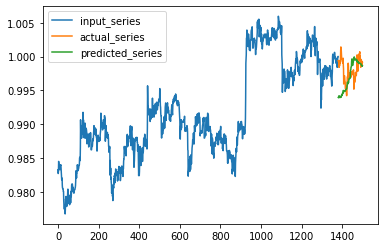

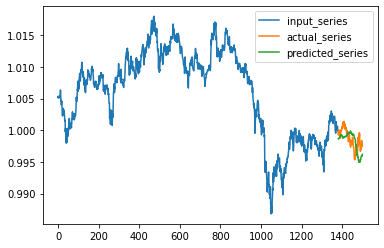

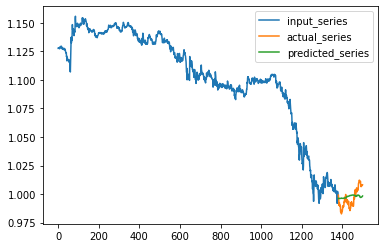

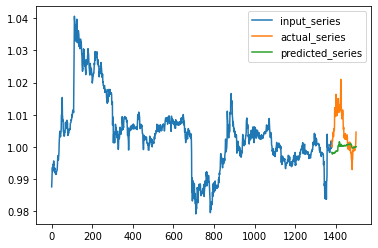

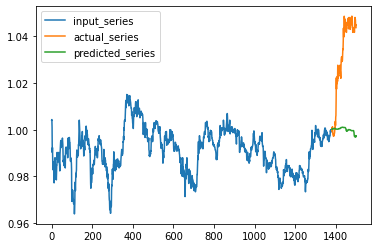

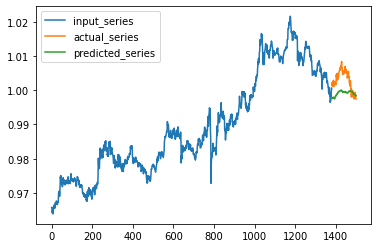

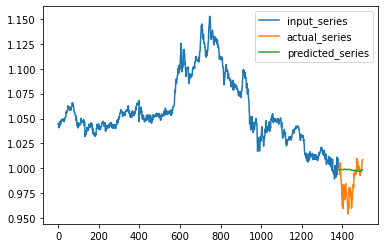

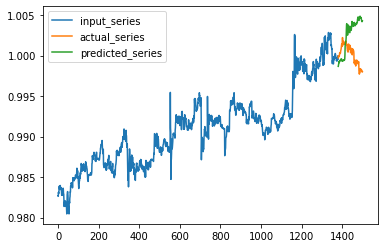

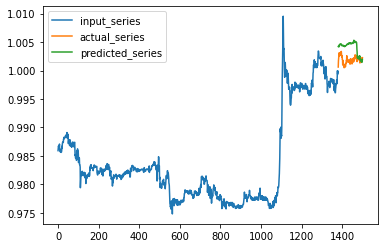

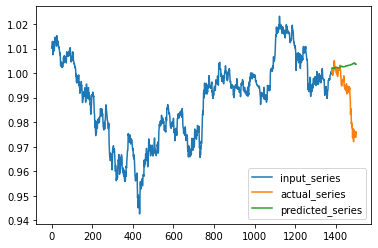

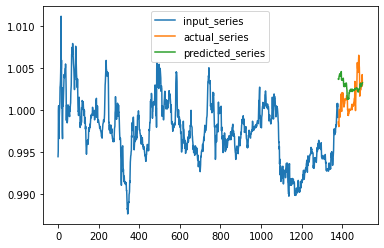

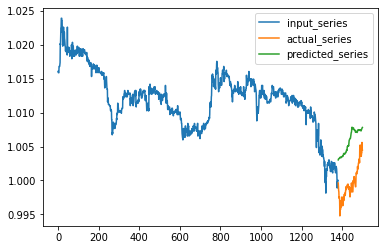

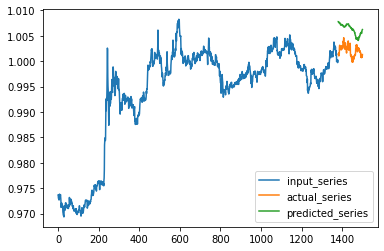

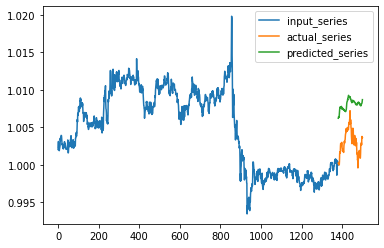

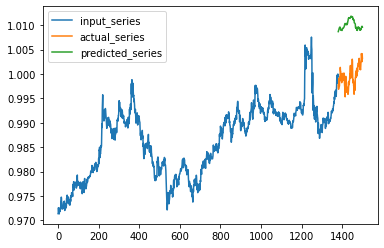

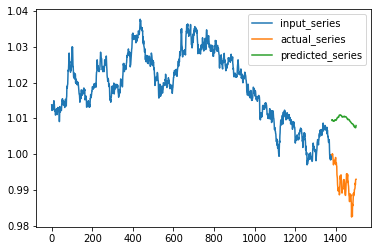

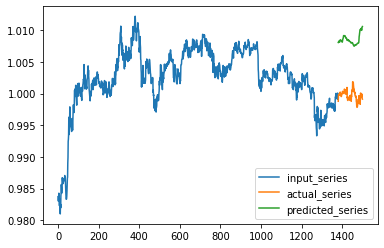

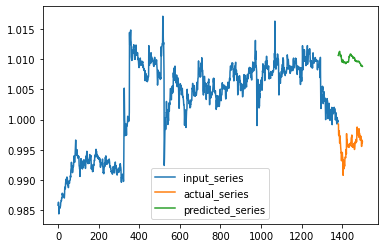

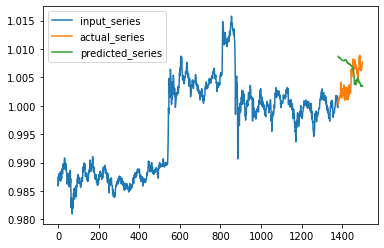

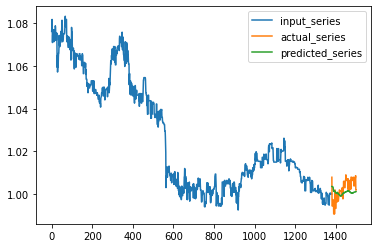

In [21]:
for i in range(20): 
    plt.figure() 
    plot_series(x_train_close[i,:], y_train_close[i,:], predicted_train[i,:])
    plt.show()